# Hyperparameter Tuning with Ray Tune

Grant Norman

October 27, 2022

## Motivation

The purpose of this notebook is to explore the Python library [Tune](https://docs.ray.io/en/latest/tune/index.html), which is for tuning hyperparameters on large problems. In class we started to discuss AutoML, where the idea is to use Reinforcement Learning to decide which hyperparameters to use. For instance, a Recurrent Neural Network can be used to learn the best set of layer widths of a Multi-layer Perceptron for a task of classification. AutoML focuses on an _outer loop_ of hyperparameter tuning, where the validation data set and metrics are used to inform changes to the hyperparameters. For instance, earlier in this class we discussed that if the validation loss started to increase past the training loss, then the model was overfitting and training should stop. In this example, the validation loss is used to inform the number of epochs as a hyperparameter. Hyperparameters, the variables to be optimized in this outer loop, are generally **not differentiable** with respect to the metric that we want to minimize. Thus, they require a separate process than methods such as stochastic gradient descent or Adam. Usually, **evaluating the outer loop optimization metric is computationally expensive**. For instance in deep learning, if we want to evaluate the performance of a model with a certain architecture, we must train the model over thousands of epochs first. As discussed in class, AutoML is one option to perform training in this outer loop. However, there are many other options to explore. The Python library includes many of these options, and provides a general framework and bookkeeping system for hyperparameter tuning. This notebook will provide examples showing how to use Tune and demonstrate some of its cool features. The focus is on the _outer loop_ of training, not about the inner loop that the past reports in this class have focused on. Thus, _many of the examples will be simplified to illustrate the points that are relevant to the outer loop_.



## Quickstart

Here we show the very basics of tune, similar to the [Quickstart](https://docs.ray.io/en/latest/tune/index.html). Unlike the quickstart, we will create a non-differentiable function as an example.

Consider $ f: [0,5] \to \mathbb{R} $ given by
$$
f(x) =
\begin{cases} 
    -x & 0 \leq x \leq 2 \\
    1 & 2 < x \leq 4.9 \\
    2 & 4.9 < x \leq 5
\end{cases}
$$

Text(0, 0.5, 'f')

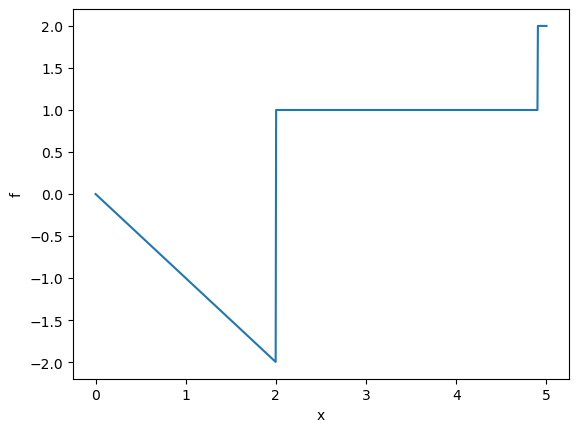

In [1]:
from ray import tune
import numpy as np
import matplotlib.pyplot as plt

def obj(config):
    # This is the function we want to optimize in some outer loop

    # config will be a dictionary, with hyperparameters strings as keys for the hyperparameter value
    # We are expecting config to have a hyperparameter 'x' to optimize over
    x = config['x']
    # With the hyperparameter set, now run the inner loop
    # (which is trivial here, but wrapped as a function to show the point)
    def run_inner_loop(x):
        # This function could be replaced by training a full neural network,
        # for instance with x as the learning rate, and generally non-differentiable wrt x
        metric = 0
        if x>2.0 and x<=4.9:
            metric+=1.0
        elif x>4.9:
            metric+=2.0
        else:
            metric-=x
        return metric
    # Return the validation error, or whatever we are trying to optimize during the outer loop
    # Return it in the same dictionary structure as the input config
    return {'metric':run_inner_loop(x)}

# Show an example of what the outer loop metric, f, may look like depending on the hyperparameter, x
xs = np.linspace(0,5,1000,True)
fs = np.zeros_like(xs)
for i,x in enumerate(xs):
    config = {'x':x}
    temp = obj(config)
    f = temp['metric']
    fs[i] = f

plt.figure()
plt.plot(xs,fs)
plt.xlabel('x')
plt.ylabel('f')

In the above we set up $f(x)$, where $f$ is our outer loop objective and $x$ is the hyperparameter we want to optimize over. By using `config`, we can pass information about the hyperparameter to the inner loop.

Note that $x^{*} := \arg \min f(x) = 2$ and $X^{**} := \arg \max f(x) = (4.9,5]$. Here, the minimum is attained a single point $x^*$ and the maximum is attained at any $x^{**} \in X^{**}$

We will use tune to look for these optimal parameter values. In practice, we would _either minimize or maximize_, but for sake of example, we will consider both.

Unlike unconstrained optimization, we must also give a search space, $X$, or a set to optimize $x$ over. Tune offers many choices for this, depending on the case. For instance, we must choose a whole number of layers or units for a neural network architecture. Or if we could also choose our inner loop optimizer from a set of choices, such as either Adam, SGD, or LBFGS.

In [2]:
# We could use either of these.
# X_space = {"x": tune.choice([0,1,2,3,4,5])}
X_space = {"x": tune.uniform(0,5)}

# Create tuners corresponding to the objective and the search space.
# This is like creating an optimizer in PyTorch, but instead for the outer loop
tuner = tune.Tuner(obj,param_space=X_space)

# Find the optimum hyperparameter. Requires running the objective a few times.
results = tuner.fit()

# Look at all the results, and choose one that is the minimum for the metric.
best_result = results.get_best_result('metric','min')
print(best_result)

2022-10-27 18:47:51,054	INFO worker.py:1518 -- Started a local Ray instance.
2022-10-27 18:47:53,575	WARNING function_trainable.py:619 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.


Trial name,status,loc,x,iter,total time (s),metric
obj_27f4c_00000,TERMINATED,127.0.0.1:12992,2.37945,1,0,1


Result for obj_27f4c_00000:
  date: 2022-10-27_18-47-57
  done: false
  experiment_id: 930620c16b1a482790595780bd489c33
  hostname: Lil_machine2
  iterations_since_restore: 1
  metric: 1.0
  node_ip: 127.0.0.1
  pid: 12992
  time_since_restore: 0.0
  time_this_iter_s: 0.0
  time_total_s: 0.0
  timestamp: 1666918077
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 27f4c_00000
  warmup_time: 0.008003950119018555
  
Result for obj_27f4c_00000:
  date: 2022-10-27_18-47-57
  done: true
  experiment_id: 930620c16b1a482790595780bd489c33
  experiment_tag: 0_x=2.3795
  hostname: Lil_machine2
  iterations_since_restore: 1
  metric: 1.0
  node_ip: 127.0.0.1
  pid: 12992
  time_since_restore: 0.0
  time_this_iter_s: 0.0
  time_total_s: 0.0
  timestamp: 1666918077
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 27f4c_00000
  warmup_time: 0.008003950119018555
  


2022-10-27 18:47:57,837	INFO tune.py:758 -- Total run time: 4.27 seconds (2.93 seconds for the tuning loop).


Result(metrics={'metric': 1.0, 'done': True, 'trial_id': '27f4c_00000', 'experiment_tag': '0_x=2.3795'}, error=None, log_dir=WindowsPath('C:/Users/grant/ray_results/obj_2022-10-27_18-47-47/obj_27f4c_00000_0_x=2.3795_2022-10-27_18-47-54'))


The above shows the general setup for how to use `tune`. However, the metric returned is not -2, so this result is not impressive. We need to make some more runs and dive into more of the settings. Some of this code is based on the [Ray Tune Documentation](https://docs.ray.io/en/latest/tune/tutorials/overview.html)

In [3]:
from ray.air.config import RunConfig
import os
import shutil

# Start with a clean save folder by removing it if it currently exists.
save_folder = './ray_results'
if os.path.exists(save_folder):
    shutil.rmtree(save_folder)

# Let's say we can run the model 10 times.
num_samples = 10

tuner = tune.Tuner(
    obj,
    tune_config=tune.TuneConfig(
        metric="metric",
        mode="min",
        num_samples=num_samples
    ),
    param_space=X_space,
    run_config=RunConfig(local_dir=save_folder,verbose=2)
)
del results
results = tuner.fit()

Trial name,status,loc,x,iter,total time (s),metric
obj_2aa40_00000,TERMINATED,127.0.0.1:26280,0.535578,1,0,-0.535578
obj_2aa40_00001,TERMINATED,127.0.0.1:25632,3.80953,1,0,1
obj_2aa40_00002,TERMINATED,127.0.0.1:17068,3.80499,1,0,1
obj_2aa40_00003,TERMINATED,127.0.0.1:30876,2.71668,1,0,1
obj_2aa40_00004,TERMINATED,127.0.0.1:3552,4.05157,1,0,1
obj_2aa40_00005,TERMINATED,127.0.0.1:6064,3.74593,1,0,1
obj_2aa40_00006,TERMINATED,127.0.0.1:21980,4.29277,1,0,1
obj_2aa40_00007,TERMINATED,127.0.0.1:15336,0.317969,1,0,-0.317969
obj_2aa40_00008,TERMINATED,127.0.0.1:29020,2.72574,1,0,1
obj_2aa40_00009,TERMINATED,127.0.0.1:18008,1.82921,1,0,-1.82921


Trial obj_2aa40_00000 reported metric=-0.54 with parameters={'x': 0.5355781852160935}.
Trial obj_2aa40_00000 completed. Last result: metric=-0.5355781852160935
Trial obj_2aa40_00005 reported metric=1.00 with parameters={'x': 3.745929986381642}.
Trial obj_2aa40_00008 reported metric=1.00 with parameters={'x': 2.7257357418973656}.
Trial obj_2aa40_00003 reported metric=1.00 with parameters={'x': 2.7166834853029584}.
Trial obj_2aa40_00002 reported metric=1.00 with parameters={'x': 3.8049912931362373}.
Trial obj_2aa40_00006 reported metric=1.00 with parameters={'x': 4.292774346637344}.
Trial obj_2aa40_00008 completed. Last result: metric=1.0
Trial obj_2aa40_00004 reported metric=1.00 with parameters={'x': 4.051568886624227}.
Trial obj_2aa40_00006 completed. Last result: metric=1.0
Trial obj_2aa40_00003 completed. Last result: metric=1.0
Trial obj_2aa40_00005 completed. Last result: metric=1.0
Trial obj_2aa40_00002 completed. Last result: metric=1.0
Trial obj_2aa40_00007 reported metric=-0.3

2022-10-27 18:48:05,463	INFO tune.py:758 -- Total run time: 7.39 seconds (7.25 seconds for the tuning loop).


At this point, we have 10 samples $\{x_i, f(x_i)\}$ generated from these 10 runs. Remember that these are generally expensive to run. We also do not know $f(x)$, so we may wish to look at $\{x_i, f(x_i)\}$ to get an idea of how our outer loop objective depends on the hyperparameter. However, this is more complicated than usual because $\{x_i, f(x_i)\}$ is within the `results` object.

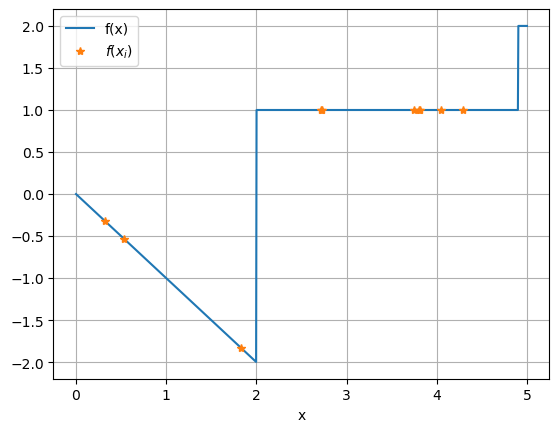

In [4]:
# One way to get the results. The results are saved too!
results_df = results.get_dataframe()

# To look at this object and figure out what we can grab...
# print(results_df)

x_runs = results_df['config/x']
f_runs = results_df['metric']

plt.figure()
plt.plot(xs,fs)
plt.plot(x_runs,f_runs,'*')
plt.xlabel('x')
plt.legend(('f(x)',r'$f(x_i)$'))
plt.grid('both')

We can also look at the "best runs" directly from the `results` object.

In [5]:
best_result = results.get_best_result()
print(type(best_result))
print(f'Metrics : {best_result.metrics}')
best_f = best_result.metrics['metric']
print(f'Best f : {best_f}')
print(f'config : {best_result.config}')
print(f'Log directory : {best_result.log_dir}')

<class 'ray.air.result.Result'>
Metrics : {'metric': -1.8292055464438195, 'time_this_iter_s': 0.0, 'done': True, 'timesteps_total': None, 'episodes_total': None, 'training_iteration': 1, 'trial_id': '2aa40_00009', 'experiment_id': '4c126367bed847468e0161edcecd8969', 'date': '2022-10-27_18-48-05', 'timestamp': 1666918085, 'time_total_s': 0.0, 'pid': 18008, 'hostname': 'Lil_machine2', 'node_ip': '127.0.0.1', 'config': {'x': 1.8292055464438195}, 'time_since_restore': 0.0, 'timesteps_since_restore': 0, 'iterations_since_restore': 1, 'warmup_time': 0.007998228073120117, 'experiment_tag': '9_x=1.8292'}
Best f : -1.8292055464438195
config : {'x': 1.8292055464438195}
Log directory : c:\Users\grant\Documents\APPM5720\biweekly-report-5-gnorman7\ray_results\obj_2022-10-27_18-47-58\obj_2aa40_00009_9_x=1.8292_2022-10-27_18-48-01


Above we see a bunch of possible ways to access the information of this best trial. We can use `.metrics` or `.metrics_dataframe` to get all the information of the trial directly in a dictionary or in a dataframe. We can separately use `.config` to get the hyperparameter settings that led to this value. We can even get the repository location, which may include more information or restart / checkpoint files. These features are really what makes `Tune` a useful library. It's relatively simple to write a for loop, generate samples, and run training iterations with these samples. The more difficult part is keeping track of all the information that is generated. In our training process we are likely generating figures and other diagnostic tools. When put in a loop, we could end up with a bunch of these figures and diagnostics, corresponding to different runs. Keeping track of which figures and diagnostics go to which hyperparameters becomes a chore, and less of the time can be spent on the actual problem. This process is automatically organized by `Tune` with implementations such as `Trial`, `Experiment`, and `Result` that generalize the inner loop.

## Smarter Sampling

In the above, we see that the samples of the hyperparameter, $\{ x_i \}$, are randomly generated. In fact, earlier, we specified for $\{ x_i \}$ to be sampled from the uniform distribution $\mathcal{U} [0,5]$. This may make sense for some hyperparameters, but for other hyperparameters, we can assume some continuity in the outer loop objective. In other words, sometimes we can assume that $\exists L \in \mathbb{R}$ for $x_1, x_2 \in X$, $|f(x_1) - f(x_2)| \leq L \cdot |x_1-x_2|$. In other words, if two hyperparameters are "close" to one another, then their objectives should also be close to each other. For some cases, this statement does not even make sense. For instance, if $X = \{ \text{Adam}, \text{SGD} \}$, then we can not even define a subtraction operator between the elements in this set. Thus, this next section only applies for some hyperparameters. The most natural example is a continuous $X$, such as choosing a learning rate hyperparameter in $[10^{-6},10^{-1}]$.

More information about Tune's search algorithms can be found [here](https://docs.ray.io/en/latest/tune/api_docs/suggestion.html#tune-search-alg), as we will only discuss a few.

We can use Bayesian Optimization to determine which parameters to look at. This is using [another package](https://github.com/fmfn/BayesianOptimization) which Tune wraps. This notebook focuses on using the method itself, but the general idea is to create a random function using a prior distribution. Then, as we get samples of $\{ f(x_i)\}$, we update our prior distribution according to this information, giving a posterior distribution. This is done with a Gaussian Process. Then, we sample again to both explore unknown parts of the function, and to try and minimize the function approximation according to our posterior distribution. These two objectives correspond to the more general idea of _exploration vs. exploitation_. In other words, Bayesian Optimization makes use of the previous assumption and provides a more intelligent way of sampling new points, which is especially helpful when our function evaluations are usually expensive. The famous [Monte Carlo Tree Search](https://en.wikipedia.org/wiki/Monte_Carlo_tree_search) (which has been used to beat the best humans at Starcraft and Go and perform faster matrix multiplication) also balances between exploration and exploitation.

In [6]:
from ray.tune.search import ConcurrencyLimiter
from ray.tune.search.bayesopt import BayesOptSearch

# We will discuss these parameters later
algo = BayesOptSearch(utility_kwargs={"kind": "ucb", "kappa": 2.5, "xi": 0.0})
algo = ConcurrencyLimiter(algo, max_concurrent=1)


In [7]:
num_samples = 10

tuner = tune.Tuner(
    obj,
    tune_config=tune.TuneConfig(
        metric="metric",
        mode="min",
        search_alg=algo,
        num_samples=num_samples
    ),
    param_space=X_space,
    run_config=RunConfig(local_dir=save_folder,verbose=2)
)
# del results
results = tuner.fit()

results_df = results.get_dataframe()
x_runs = results_df['config/x']
f_runs = results_df['metric']


2022-10-27 18:48:06,621	WARNING bayesopt_search.py:423 -- BayesOpt does not support specific sampling methods. The Uniform sampler will be dropped.


Trial name,status,loc,x,iter,total time (s),metric
obj_2fbb79e6,TERMINATED,127.0.0.1:5232,1.8727,1,0,-1.8727
obj_317a5d37,TERMINATED,127.0.0.1:28940,4.75357,1,0,1
obj_330987b3,TERMINATED,127.0.0.1:14516,3.65997,1,0,1
obj_347b35f5,TERMINATED,127.0.0.1:31724,2.99329,1,0,1
obj_35ea7953,TERMINATED,127.0.0.1:8852,0.780093,1,0,-0.780093
obj_37508644,TERMINATED,127.0.0.1:26764,0.779973,1,0,-0.779973
obj_38d22815,TERMINATED,127.0.0.1:24336,0.290418,1,0,-0.290418
obj_3a3536f5,TERMINATED,127.0.0.1:30184,4.33088,1,0,1
obj_3ba85887,TERMINATED,127.0.0.1:29216,3.00558,1,0.00747371,1
obj_3d188f13,TERMINATED,127.0.0.1:29268,3.54036,1,0,1


Trial obj_2fbb79e6 reported metric=-1.87 with parameters={'x': 1.8727005942368125}.
Trial obj_2fbb79e6 completed. Last result: metric=-1.8727005942368125
Trial obj_317a5d37 reported metric=1.00 with parameters={'x': 4.75357153204958}.
Trial obj_317a5d37 completed. Last result: metric=1.0
Trial obj_330987b3 reported metric=1.00 with parameters={'x': 3.6599697090570253}.
Trial obj_330987b3 completed. Last result: metric=1.0
Trial obj_347b35f5 reported metric=1.00 with parameters={'x': 2.993292420985183}.
Trial obj_347b35f5 completed. Last result: metric=1.0
Trial obj_35ea7953 reported metric=-0.78 with parameters={'x': 0.7800932022121826}.
Trial obj_35ea7953 completed. Last result: metric=-0.7800932022121826
Trial obj_37508644 reported metric=-0.78 with parameters={'x': 0.7799726016810132}.
Trial obj_37508644 completed. Last result: metric=-0.7799726016810132
Trial obj_38d22815 reported metric=-0.29 with parameters={'x': 0.2904180608409973}.
Trial obj_38d22815 completed. Last result: met

2022-10-27 18:48:31,676	INFO tune.py:758 -- Total run time: 25.06 seconds (24.93 seconds for the tuning loop).


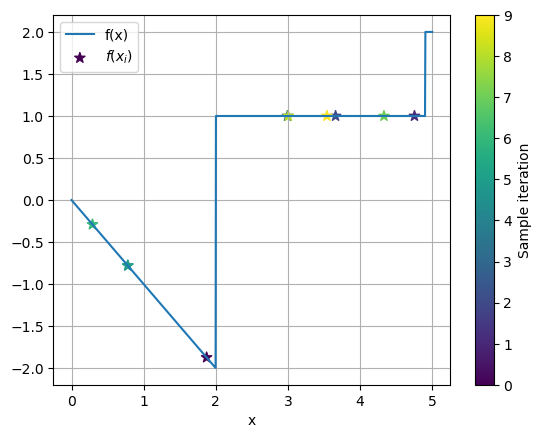

In [8]:
plt.figure()
plt.plot(xs,fs)
plt.scatter(x_runs,f_runs,s=60,c=np.arange(len(x_runs)),marker='*')
plt.xlabel('x')
plt.legend(('f(x)',r'$f(x_i)$'))
plt.grid('both')
cb = plt.colorbar()
cb.set_label('Sample iteration')

### Make some changes to the Bayesian Optimization

The Bayesian Optimization method itself has hyperparameters that we can tune. Before, we mentioned that Bayesian Optimization must trade off between exploration and exploitation. Exploitation would place new points near the current best point, hoping that the neighbor is a little better. Exploration would place new points farther away, in unexplored regions, hoping to find that the function performs well there. We can balance the tradeoff between these two competing objectives with a hyperparameter $\kappa$. To find this parameter, we looked at Tune examples and the [package providing Bayesian Optimization](https://github.com/fmfn/BayesianOptimization/blob/master/examples/exploitation_vs_exploration.ipynb). A large value of $\kappa$ will prefer exploitation, while a small value of $\kappa$ will prioritize exploration. $\xi$ plays a similar role, but through a different method within the Bayesian Optimization formulation. We will show examples of both exploration and exploitation.

For completeness, `"kind": "ucb"` specifies to use an upper confidence bound, rather than an expected improvement. More information is on [Wikipedia](https://en.wikipedia.org/wiki/Bayesian_optimization) and [here](https://github.com/fmfn/BayesianOptimization) which also includes some really cool visualizations about the method. It's definitely worth checking out!

In [9]:
def run_outer_loop(kappa):
    algo = BayesOptSearch(utility_kwargs={"kind": "ucb", "kappa": kappa, "xi": kappa/100})
    algo = ConcurrencyLimiter(algo, max_concurrent=1)
    
    num_samples = 20

    tuner = tune.Tuner(
        obj,
        tune_config=tune.TuneConfig(
            metric="metric",
            mode="min",
            search_alg=algo,
            num_samples=num_samples
        ),
        param_space=X_space,
        run_config=RunConfig(local_dir=save_folder,verbose=1)
    )
    # del results
    results = tuner.fit()

    results_df = results.get_dataframe()
    x_runs = results_df['config/x']
    f_runs = results_df['metric']

    f = plt.figure()
    plt.plot(xs,fs)
    plt.scatter(x_runs,f_runs,s=60,c=np.arange(len(x_runs)),marker='*')
    plt.xlabel('x')
    plt.legend(('f(x)',r'$f(x_i)$'))
    plt.grid('both')
    cb = plt.colorbar()
    cb.set_label('Sample iteration')
    return f

2022-10-27 18:49:26,401	INFO tune.py:758 -- Total run time: 54.44 seconds (54.31 seconds for the tuning loop).


Text(0.5, 1.0, '$\\kappa=1.0$')

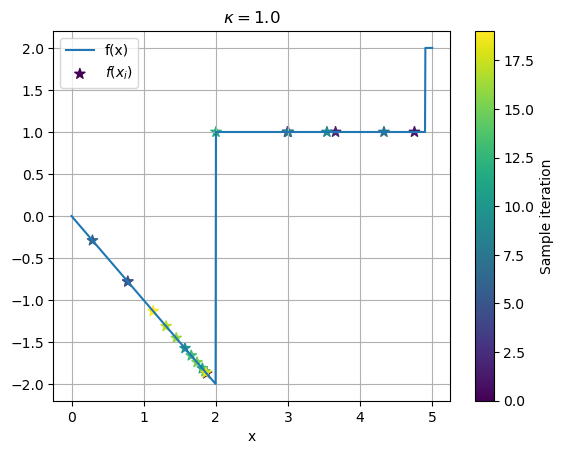

In [10]:
k1 = 1.0
k2 = 10.0
run_outer_loop(k1)
plt.title(rf'$\kappa={k1}$')


The example above shows that the Bayesian Optimization does a little exploring (6 points on $2<x\leq 4.9$), but mostly focuses on the area near $1 \leq x \leq 2$. ALso note that most of the points in this area are from later iterations. In other words, the Bayesian Optimization explores the function a little, but quickly decides to focus on the area where it has seen the most success. THis is what we would expect for prioritizing exploitation.

Now we can change the balance to be in favor of exploration.

2022-10-27 18:50:16,445	INFO tune.py:758 -- Total run time: 49.78 seconds (49.64 seconds for the tuning loop).


Text(0.5, 1.0, '$\\kappa=10.0$')

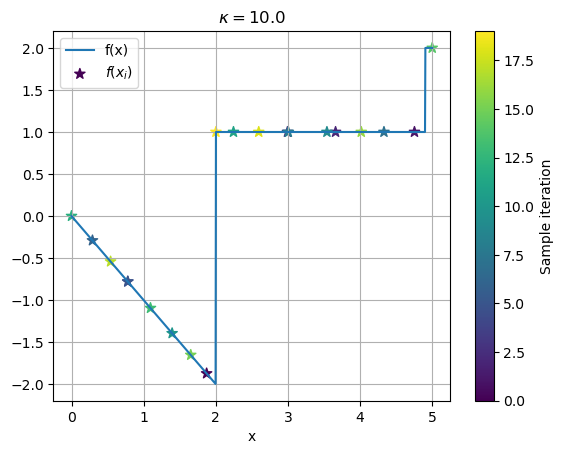

In [11]:
run_outer_loop(k2)
plt.title(rf'$\kappa={k2}$')

Here, we see a much more even distribution of $\{ x_i \}$ throughout the domain. We even end up with a point in the $4.9 < x \leq 5$ region (which has a 40% chance to happen if we randomly sample 20 points). Also, the later iterations do not group in one area. In fact, the later iteration tend to bisect earlier iterations, as a way to sample an unknown area of the domain.

### No Free Lunch

With the introduction of Bayesian Optimization to perform the outer loop optimization and remove the hyperparameters governing the inner loop, we introduced more hyperparameters to control this outer loop process.
> Whoever fights monsters should see to it that in the process he does not become a monster. And if you gaze long enough into an abyss, the abyss will gaze back into you. 

$-$ Friedrich Nietzsche

![image](meme.jpeg)

In all seriousness, this is an improvement. The hyperparameters $\xi$ and $\kappa$ do carry some complexity based on their formal definition in Bayesian Optimization, but we can easily conceptualize their role as _exploration vs. exploitation_. This allows for better intuition than deciding on a learning rate. It's difficult to think of an example where before any training we just think that there should be a low learning rate. On the other hand, it's easier to conceptualize exploring different neural network architectures to see if we get lucky. Thus, the hyperparameters that we introduced are easier to work with, require less fine tuning, and generalize to control all of the original hyperparameters (i.e. $\xi$ and $\kappa$ would control the preprocessing, architecture, and optimizer).

## Conclusion

Motivated by our discussion of AutoML in class, this notebook explores the library Tune and its included wrapper of a Bayesian Optimization algorithm. Tune is a package for hyperparameter tuning in deep learning applications. A key feature that Tune provides is its bookkeeping, tracking and organizing different hyperparameter runs. With a brief tutorial, we show the basics of how to use Tune for deep learning, but we instead use a simple function to represent the inner loop, as using an actual deep learning loop would require lots of computation and take away from the main points of this notebook. We also explore Bayesian Optimization within the Tune library, which allows for the hyperparameters to be sampled more intelligently, based on previous samples within the outer loop. A key idea in Bayesian Optimization is exploration vs. exploitation, which we demonstrate with an example. Finally, we argue that while this automated outer loop introduced more hyperparameters, that these hyperparameters are better to work with than the original ones.